**Notebook dédié à:** 


* la contruction de la matrice Document-Entités. 
* l'entrainement du Kmeans et spherical kmeans  sur cette matrice.

# Importer les librairies 

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from scipy import  sparse
from wordcloud import WordCloud 
import re


In [90]:
pip install spacy==3.1.3

In [91]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 71 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [92]:
pip install spacy-transformers

In [93]:
pip install spacy-entity-linker

In [94]:
!python -m spacy_entity_linker "download_knowledge_base"

In [95]:
import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')
# add pipeline (declared through entry_points in setup.py)
nlp.add_pipe("entityLinker",last= True)

In [116]:
pip install coclust

  Created wheel for coclust: filename=coclust-0.2.1-py3-none-any.whl size=29870 sha256=6257decae5ae64a2dd16ce0ec29cfbefa35a3e9cd1afcdc9367d4ad895911d41
  Stored in directory: /root/.cache/pip/wheels/78/e9/dc/3f80429511bb4aa68ebf39a0f141661230809490d53557ce4a
Successfully built coclust


In [132]:
import coclust
from coclust.clustering import SphericalKmeans
from coclust.visualization import plot_cluster_top_terms

# Importer les données 

In [96]:
DF=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Intelligence/Projet /DBLP_Subset_processed.txt')

In [97]:
abstract_lemmatized = DF['Abstract']


# Matrice Document-Entité 

## Détection des entités nommées 

In [98]:
listEntity=[]
for a,abs in enumerate(abstract_lemmatized):
  doc = nlp(str(abs))
  listInter=[]
  #returns all entities in the whole document
  all_linked_entities = doc._.linkedEntities
  #iterates over sentences ans prints linke entities
  for sent in doc.sents:
    for i in range(len(sent._.linkedEntities)):
      
      #entity=sent._.linkedEntities[i].get_id()
      entity=sent._.linkedEntities[i]

      listInter.append(entity)
  listEntity.append(listInter)

## Matrice Documents-Entités 

In [99]:
list_entity=[]

for l in listEntity:
  string = ' '.join([str(item) for item in l]) 
  list_entity.append(string)

#len(list_entity)

In [100]:
# Vectorizer 
vectorizer = CountVectorizer()
MatEntityDoc = vectorizer.fit_transform(list_entity)
MatEntityDoc

<17633x9462 sparse matrix of type '<class 'numpy.int64'>'
	with 292970 stored elements in Compressed Sparse Row format>

#Kmeans sur la matrice Documents-Entité 

## Déterminer le nombre de clusters optimal en utilisant la methode Elbow 

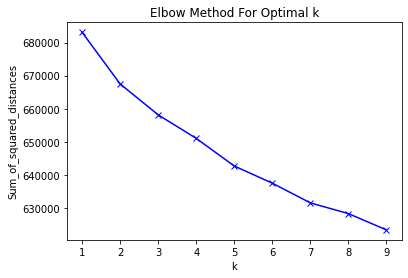

In [101]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(MatEntityDoc)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Remarque:**
*   Nous remarquons que la méthode elbow dans notre cas ne nous permet pas d'identifier l'existance d'un coude. 
Néanmoins, k=4 peut être une bonne valeur pour initialiser le nombre de clusters pour lancer le kmeans. 

# Kmeans 

In [102]:
km = KMeans(n_clusters=4, max_iter=100, n_init=5,random_state=0)
km = km.fit(MatEntityDoc)   

In [103]:
labels= km.labels_

In [104]:
cluster_center=km.cluster_centers_

In [105]:
# assigner un cluster à chaque abstract ( sorte de label)
DF['Bow Clus Label'] = labels  # la dernière colonne du DF représente le numéro du label 
DF.head(2)

,Pub_Venue,Year,Authors,Title,Index,Id,Abstract,Bow Clus Label
0,DAC,1988,"['Chung-Kuan Cheng', 'David N. Deutsch']",Improved Channel Routing by Via Minimization a...,131751,"['133716', '133521', '134343']",channel routing area improvement mean via mini...,1
1,DAC,2006,"['Lei Cheng', 'Liang Deng', 'Deming Chen', 'Ma...",A fast simultaneous input vector generation an...,131752,"['132550', '530568', '436486', '134259', '2830...",input vector control ivc technique observation...,1


## Evaluation des résultats du clustering 

### Visualiser la distribution des articles à travers les  clusters 

In [106]:
# Combien d'articles appartiennent à chaque cluster
DF.groupby(['Bow Clus Label'])['Title'].count()

Bow Clus Label
0      306
1    14233
2     1679
3     1415
Name: Title, dtype: int64

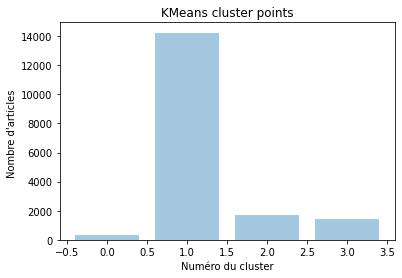

In [107]:
#visualiser comment les articles sont distribués à travers les 4 clusters 

plt.bar([x for x in range(4)], DF.groupby(['Bow Clus Label'])['Abstract'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Numéro du cluster")
plt.ylabel("Nombre d'articles ")
plt.show()

**Remarque:**
*   On remarque que le cluster contenant le plus d'articles est le cluster n°1 avec 14233 articles.
*   Les articles ne sont pas distribués de manière uniforme entre les différents clusters?

### Affichage du TOP 10 des termes présents dans chaque cluster

In [108]:
# Trouver le top 10 termes présents dans chaque cluster
print("Top 10 des termes pour chaque cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top 10 des termes pour chaque cluster:
Cluster 0: question
 mark
 data
 database
 system
 time
 means
 language
 user
 algorithm
Cluster 1: mathematical
 computer
 time
 result
 design
 algorithm
 of
 function
 system
 solution
Cluster 2: system
 computer
 software
 mathematical
 design
 data
 database
 application
 language
 time
Cluster 3: data
 database
 computer
 system
 type
 application
 structure
 mathematical
 algorithm
 time


**Remarque**:
*  On remarque qu'il y'a des termes qui se répètent dans les 4 clusters. ça pourrait laisser croire que nos clusters ne sont pas formés sur la base des sujets qu'ils traitent.

### Distribution des clusters par revue

In [109]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().head(50)

Pub_Venue                          Bow Clus Label
DAC                                1                 1787
                                   2                  167
                                   3                   77
DAGM-Symposium                     1                   59
                                   2                    5
                                   3                    4
DATA BASE                          1                  161
                                   2                   41
                                   3                   12
Data Min. Knowl. Discov.           0                    2
                                   1                   82
                                   2                   11
                                   3                   86
Des. Codes Cryptography            1                  611
                                   2                   18
                                   3                   19
Discrete Applied Mathe

In [110]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().tail(50)

Pub_Venue                        Bow Clus Label
ICCE                             1                   46
                                 2                    9
ICCSA (1)                        1                  117
                                 2                   22
                                 3                   13
ICCSA (2)                        0                    2
                                 1                  120
                                 2                   15
                                 3                    8
ICCSA (3)                        0                    1
                                 1                  112
                                 2                   17
                                 3                   14
ICCV                             1                   72
                                 3                    4
ICIP                             0                    1
                                 1                  720


**Remarque:**



*   On remarque que les articles de chaque revue sont affectés à un cluster en particulier. 

**Remarque:**

### Fréquence d'apparition de chaque revue par cluster

In [111]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().head(50)

Bow Clus Label  Pub_Venue                        
0               Data Min. Knowl. Discov.                2
                Discrete Applied Mathematics            3
                Electr. Notes Theor. Comput. Sci.       3
                ICC                                     1
                ICCBR                                   1
                ICCSA (2)                               2
                ICCSA (3)                               1
                ICIP                                    1
                IJCAI                                   8
                Journal of Systems and Software        16
                Knowl. Inf. Syst.                       2
                SIGMOD Conference                     243
                SIGMOD Record                          19
                SMC                                     2
                STOC                                    2
1               DAC                                  1787
                DAGM-S

In [112]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().tail(50)

Bow Clus Label  Pub_Venue                        
2               Des. Codes Cryptography               18
                Discrete Applied Mathematics          22
                Distributed Computing                 39
                Electr. Notes Theor. Comput. Sci.    291
                GECCO                                103
                GECCO (Companion)                     22
                GECCO Workshops                        5
                ICC                                   40
                ICCAD                                113
                ICCBR                                 12
                ICCE                                   9
                ICCSA (1)                             22
                ICCSA (2)                             15
                ICCSA (3)                             17
                ICIP                                  31
                IJCAI                                211
                IJCAI (1)             

**Remarque:**
*  cluster 0: SIGMOD Conference (243)
*  cluster 1: Les revues qui apparaissent le plus fréquemment sont:  

DAC (1787 articles ), IJCAI (1614 articles ),Electr. Notes Theor. Comput. Sci. (1523 articles ), ICCAD (1494 articles ), GECCO (1307 articles ) et Discrete Applied Mathematics (1284 articles ). 

Ce cluster regroupe des articles issus de différrents types de revues, ce qui pourrait remettre en cause le résultat de ce clustering.

*  cluster 2: Electr. Notes Theor. Comput. Sci. (291 articles ) et IJCAI (211 articles )

*  cluster 3: SIGMOD Conference (479 articles ) et SIGMOD Record (115 articles ) 


On voit qu'il y'a des clusters pour lesquels les revues dominantes se répètent. 

### Fréquence d'apparition des années de publication d'articles par cluster 

In [113]:
DF.groupby(['Bow Clus Label','Year'])['Year'].count().head(60)

Bow Clus Label  Year
0               1979      2
                1980      1
                1981      3
                1982      2
                1983      4
                1986      4
                1987      6
                1988      2
                1989      3
                1990      8
                1991      2
                1992      6
                1993      7
                1994      3
                1995      7
                1996      8
                1997      5
                1998     15
                1999     11
                2000     10
                2001     13
                2002     19
                2003     15
                2004     23
                2005     14
                2006     25
                2007     18
                2008     21
                2009     24
                2010     25
1               1969     13
                1971     19
                1973     28
                1975     58
                1976      6

In [114]:
DF.groupby(['Bow Clus Label','Year'])['Year'].count().tail(60)

Bow Clus Label  Year
2               1988     17
                1989     42
                1990     15
                1991     19
                1992     16
                1993     31
                1994     14
                1995     54
                1996     14
                1997     38
                1998     38
                1999     34
                2000     24
                2001     43
                2002     49
                2003    106
                2004     69
                2005    157
                2006     96
                2007    198
                2008    174
                2009    229
                2010     38
3               1973      1
                1975     13
                1976      6
                1977      8
                1978      5
                1979      2
                1980      4
                1981      9
                1982      9
                1983     10
                1984     10
                1985      2

**La classification des documents en utilisant un kmeans sur la matrice entité-document n'a pas donné de résultats significatifs, comparé au clustering sur la matrice documents-terms.**



# Spherical kmeans 

In [118]:
# spherical kmeans vectorizer
vectorizer = CountVectorizer(max_features=1000)
MatEntityDoc1 = vectorizer.fit_transform(list_entity)
MatEntityDoc1

<17633x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 251993 stored elements in Compressed Sparse Row format>

In [125]:
Skm = SphericalKmeans(n_clusters=4, max_iter=20, n_init=1,random_state=0)
Skmean = Skm.fit(MatEntityDoc1)

 == New init == 
iteration: 0
3019.419546456198
iteration: 1
3416.168105066581
iteration: 2
3604.536482999103
iteration: 3
3663.9316829622812
iteration: 4
3683.5250218672118
iteration: 5
3694.4092886746093
iteration: 6
3701.5178251396246
iteration: 7
3707.850864178645
iteration: 8
3713.845181751737
iteration: 9
3718.7059208673904
iteration: 10
3721.6913763811517
iteration: 11
3723.2373416808077
iteration: 12
3724.022844938051
iteration: 13
3724.588922279624
iteration: 14
3725.0468843540666
iteration: 15
3725.429566008847
iteration: 16
3725.852719235444
iteration: 17
3726.333262506938
iteration: 18
3726.9020310220612
iteration: 19
3727.412031533853


In [126]:
skm_labels= Skm.labels_

In [129]:
# assigner un cluster à chaque abstract ( sorte de label)
DF['Bow Clus Label'] = skm_labels  
DF.head(2)

,Pub_Venue,Year,Authors,Title,Index,Id,Abstract,Bow Clus Label
0,DAC,1988,"['Chung-Kuan Cheng', 'David N. Deutsch']",Improved Channel Routing by Via Minimization a...,131751,"['133716', '133521', '134343']",channel routing area improvement mean via mini...,1
1,DAC,2006,"['Lei Cheng', 'Liang Deng', 'Deming Chen', 'Ma...",A fast simultaneous input vector generation an...,131752,"['132550', '530568', '436486', '134259', '2830...",input vector control ivc technique observation...,1


## Evaluation des résultats du clustering 

### Visualiser la distribution des articles à travers les clusters 

In [130]:
# Combien d'articles appartiennent à chaque cluster
DF.groupby(['Bow Clus Label'])['Title'].count()

Bow Clus Label
0    4251
1    5421
2    2641
3    5320
Name: Title, dtype: int64

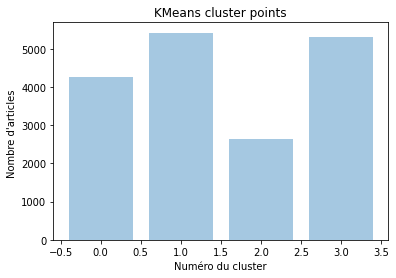

In [131]:
#visualiser comment les articles sont distribués à travers les 4 clusters 

plt.bar([x for x in range(4)], DF.groupby(['Bow Clus Label'])['Abstract'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Numéro du cluster")
plt.ylabel("Nombre d'articles ")
plt.show()

**Remarque**
*  On remarque que la distribution des documents à travers les clusters en utilisant le spherical kmeans  est plus uniforme qu'avec le kmeans classique.

### Distribution des clusters par revues 

In [164]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().head(57)

Pub_Venue                          Bow Clus Label
DAC                                0                  206
                                   1                 1287
                                   2                  164
                                   3                  374
DAGM-Symposium                     0                   15
                                   1                   29
                                   2                    5
                                   3                   19
DATA BASE                          0                   11
                                   1                   20
                                   2                   34
                                   3                  149
Data Min. Knowl. Discov.           0                   33
                                   1                   22
                                   2                   49
                                   3                   77
Des. Codes Cryptograph

In [162]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().tail(60)

Pub_Venue                        Bow Clus Label
ICCBR                            0                  34
                                 1                   4
                                 2                   4
                                 3                  29
ICCE                             0                   3
                                 1                   3
                                 2                   2
                                 3                  47
ICCSA (1)                        0                  33
                                 1                  39
                                 2                  25
                                 3                  55
ICCSA (2)                        0                  17
                                 1                  54
                                 2                  13
                                 3                  61
ICCSA (3)                        0                  38
                 

In [172]:
DF.groupby(['Pub_Venue'])['Bow Clus Label'].count()

Pub_Venue
DAC                                  2031
DAGM-Symposium                         68
DATA BASE                             214
Data Min. Knowl. Discov.              181
Des. Codes Cryptography               648
Discrete Applied Mathematics         1335
Distributed Computing                 224
Electr. Notes Theor. Comput. Sci.    1909
GECCO                                1472
GECCO (Companion)                     269
GECCO Workshops                        66
ICC                                   587
ICCAD                                1666
ICCBR                                  71
ICCE                                   55
ICCSA (1)                             152
ICCSA (2)                             145
ICCSA (3)                             144
ICCV                                   76
ICIP                                  812
IJCAI                                1905
IJCAI (1)                              83
Journal of Systems and Software       916
Knowl. Inf. Syst.       

### Fréquence d'apparition de chaque revue par cluster 

In [148]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().head(50)

Bow Clus Label  Pub_Venue                        
0               DAC                                   206
                DAGM-Symposium                         15
                DATA BASE                              11
                Data Min. Knowl. Discov.               33
                Des. Codes Cryptography               517
                Discrete Applied Mathematics         1088
                Distributed Computing                  72
                Electr. Notes Theor. Comput. Sci.     328
                GECCO                                 572
                GECCO (Companion)                      82
                GECCO Workshops                        17
                ICC                                   114
                ICCAD                                 176
                ICCBR                                  34
                ICCE                                    3
                ICCSA (1)                              33
                ICCSA 

In [165]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().tail(50)

Bow Clus Label  Pub_Venue                        
2               Distributed Computing                 15
                Electr. Notes Theor. Comput. Sci.    356
                GECCO                                 90
                GECCO (Companion)                     15
                GECCO Workshops                        3
                ICC                                   17
                ICCAD                                 79
                ICCBR                                  4
                ICCE                                   2
                ICCSA (1)                             25
                ICCSA (2)                             13
                ICCSA (3)                             12
                ICCV                                   4
                ICIP                                  55
                IJCAI                                247
                IJCAI (1)                              9
                Journal of Systems and

**Remarque:**
*  cluster 0: la majorité des articles de cette classe sont issue de la revue Discrete Applied Mathematics (1088 articles).

*  cluster 1: la revue majoritaire présente dans ce cluster est DAC avec 1287 articles, suivi de ICCAD avec 1240 articles. 

*  cluster 2: la revue majoritaire est SIGMOD Conference avec 985 articles.

*  cluster 3: la revue majoritaire est Electr. Notes Theor. Comput. Sci.  avec 930 articles, suivi de  IJCAI avec 892 articles.

On remarque que ces clusters sont similaires aux résultats de clustering obtenus en utilisant le kmeans sur la matrice TF-IDF et le Spherical kmeans sur la matrice BOW.

Le spherical kmeans donne une meilleure répartition des articles dans les clusters.

On peut donc conclure que les clusters sont construits selon le type des revues.


# Conclusion

> Après les différentes expérimentations menées sur les abstracts des documents, nous pouvons dire que le meilleur modèle pour la classification textuelle a été le spherical kmeans et ce sur les différentes matrices représentant les documents.    

> De plus le fait que les documents traitent tous des thèmatiques relativement proches rend la tâche de classification plus complexe. 